I initially had a hard time understanding the tensor dimensions defining the conv layers in PyTorch. I went through several different variatios of architectures before I got one that made sense to me. I also had some issues with getting the tensor dimensions of the residual connections correct.

I used Sonnet 4.5 and GPT-5.1 to help me with creating the PyTorch code. CIFAR data can be downloaded by running `torchvision.datasets.CIFAR10(root='./data', train=False, download=True)` and `torchvision.datasets.CIFAR10(root='./data', train=True, download=True)`

This was an individual project and I did everything in it.


## Analyze Dataset

In [ ]:
## Analyze Dataset
import torchvision
# torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

import matplotlib.pyplot as plt

# Load the dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False)

# Basic info
print(f"Number of samples: {len(trainset)}")
print(f"Image shape: {trainset[0][0].size}")  # PIL Image size (width, height)
print(f"Number of classes: {len(trainset.classes)}")
print(f"Classes: {trainset.classes}")

# Look at a single sample
image, label = trainset[0]
print(f"Label: {label} ({trainset.classes[label]})")

# Display some images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    img, lbl = trainset[i]
    ax.imshow(img)
    ax.set_title(trainset.classes[lbl])
    ax.axis('off')
plt.tight_layout()
plt.show()

# Task 1

My vanilla CNN had 814,122 parameters and had the following architecture:
```
  Input
    │
    ▼
  ┌─────────────────────────────────┐
  │ Block 1                         │
  │  conv1a (3→32) ──► ReLU         │
  │  conv1b (32→32) ──► ReLU        │
  │  MaxPool 2x2                    │
  └─────────────────────────────────┘
    │
    ▼
  ┌─────────────────────────────────┐
  │ Block 2                         │
  │  conv2a (32→64) ──► ReLU        │
  │  conv2b (64→64) ──► ReLU        │
  │  MaxPool 2x2                    │
  └─────────────────────────────────┘
    │
    ▼
  ┌─────────────────────────────────┐
  │ Block 3                         │
  │  conv3a (64→128) ──► ReLU       │
  │  conv3b (128→128) ──► ReLU      │
  │  MaxPool 2x2                    │
  └─────────────────────────────────┘
    │
    ▼
  Flatten
    │
    ▼
  fc1 ──► ReLU
    │
    ▼
  fc2
    │
    ▼
  Output
```

## Define Model

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN_task1(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1: 32 -> 16
        self.conv1a = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        
        # Block 2: 16 -> 8
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # Block 3: 8 -> 4
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        
        # Print parameter count
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

    def forward(self, x):
        # Block 1: 32 -> 16
        x = F.relu(self.conv1a(x))
        x = F.relu(self.conv1b(x))
        x = self.pool(x)
        
        # Block 2: 16 -> 8
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2b(x))
        x = self.pool(x)
        
        # Block 3: 8 -> 4
        x = F.relu(self.conv3a(x))
        x = F.relu(self.conv3b(x))
        x = self.pool(x)
        
        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Get Data

In [82]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Pad by 4, then crop back to 32x32
    transforms.RandomHorizontalFlip(),      # 50% chance to flip
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Test transforms (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets with transforms
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transform)

# Data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

print(f"Train samples: {len(trainset)}, Test samples: {len(testset)}")

Train samples: 50000, Test samples: 10000


## Train Model

In [91]:
from tqdm import tqdm
from IPython.display import display, clear_output

def train(model, num_epochs=10, lr=1e-3, dataloader=None):
    """Train a model on CIFAR-10."""
    # Use custom dataloader or default trainloader
    loader = dataloader if dataloader is not None else trainloader
    
    # Move model to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Training on: {device}")
    
    # Setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Track losses for plotting
    step_losses = []
    
    # Setup live plot
    fig, ax = plt.subplots(figsize=(8, 5))
    
    step = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Track stats
            step_losses.append(loss.item())
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            step += 1
            
            # Update plot every 50 steps
            if step % 50 == 0:
                clear_output(wait=True)
                ax.clear()
                ax.plot(step_losses)
                ax.set_xlabel('Step')
                ax.set_ylabel('Loss')
                ax.set_title(f'Training Loss (Epoch {epoch+1}/{num_epochs}, Acc: {100.*correct/total:.2f}%)')
                ax.grid(True)
                display(fig)
        
        print(f"Epoch {epoch+1} complete - Loss: {running_loss/len(loader):.4f}, Acc: {100.*correct/total:.2f}%")
    
    plt.close(fig)
    
    return model

## Evaluate on Test

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate(model):
    """Evaluate model on test set."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    criterion = nn.CrossEntropyLoss()
    
    correct = 0
    total = 0
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(testloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_acc = 100. * correct / total
    avg_loss = running_loss / len(testloader)
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
    
    # Confusion matrix
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return avg_loss, test_acc

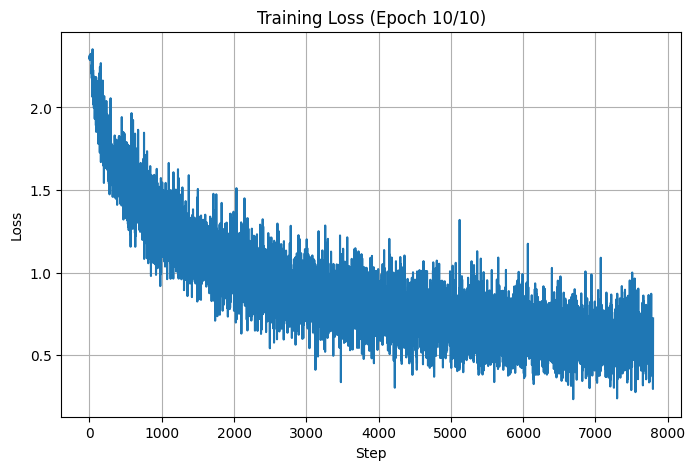

Epoch 10 complete - Loss: 0.5932, Acc: 79.41%


Evaluating: 100%|██████████| 157/157 [00:04<00:00, 33.24it/s]


Test Loss: 0.6427, Test Accuracy: 78.30%


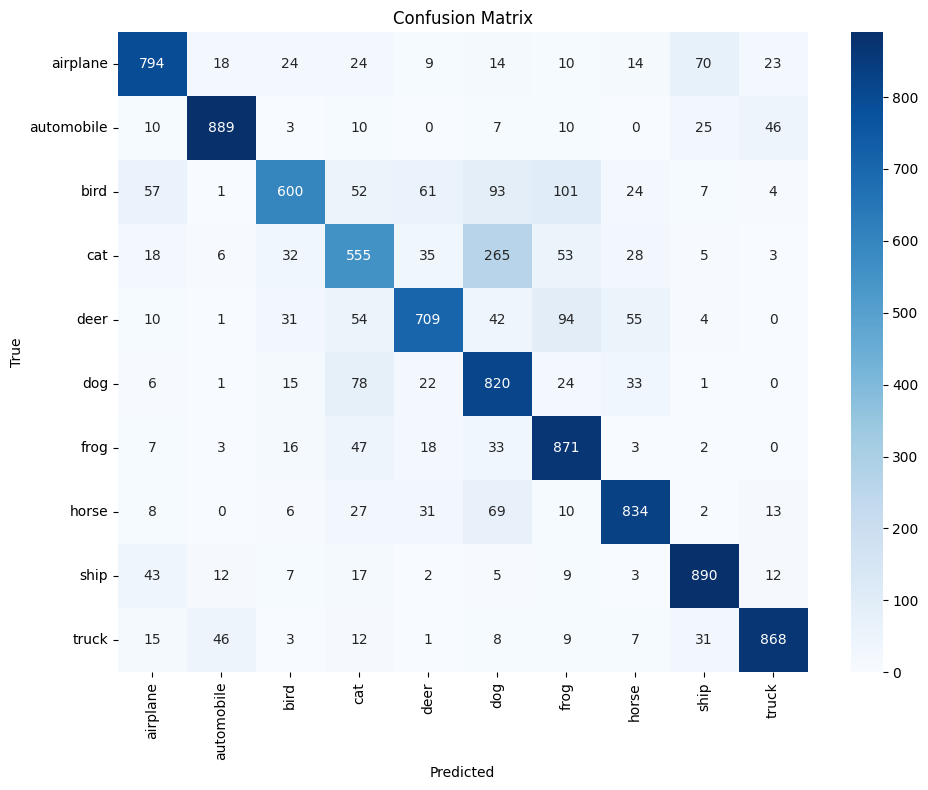

(0.6426620967448897, 78.3)

In [ ]:
model = CNN_task1()
model = train(model, num_epochs=10)
evaluate(model)

# Task 2

## Architecture

My residual based CNN had 824,682 parameters and had a skip connection at the beginning of every block:
```
  CNN_task2 (Residual CNN):
  Input
    │
    ▼
  ┌───────────────────────────────────┐
  │ Block 1                           │
  │                                   │
  │  x ──► conv1a ──► ReLU            │
  │  │         │                      │
  │  │         ▼                      │
  │  │      conv1b                    │
  │  │         │                      │
  │  ▼         ▼                      │
  │  shortcut1─(+)──► ReLU            │
  │                                   │
  │  MaxPool 2x2                      │
  └───────────────────────────────────┘
    │
    ▼
  ┌───────────────────────────────────┐
  │ Block 2                           │
  │                                   │
  │  x ──► conv2a ──► ReLU            │
  │  │         │                      │
  │  │         ▼                      │
  │  │      conv2b                    │
  │  │         │                      │
  │  ▼         ▼                      │
  │  shortcut2─(+)──► ReLU            │
  │                                   │
  │  MaxPool 2x2                      │
  └───────────────────────────────────┘
    │
    ▼
  ┌───────────────────────────────────┐
  │ Block 3                           │
  │                                   │
  │  x ──► conv3a ──► ReLU            │
  │  │         │                      │
  │  │         ▼                      │
  │  │      conv3b                    │
  │  │         │                      │
  │  ▼         ▼                      │
  │  shortcut3─(+)──► ReLU            │
  │                                   │
  │  MaxPool 2x2                      │
  └───────────────────────────────────┘
    │
    ▼
  Flatten
    │
    ▼
  fc1 ──► ReLU
    │
    ▼
  fc2
    │
    ▼
  Output
```

## Comparison

 <table>
  <tr>
  <td><img src="training_curves/vanilla_train.png" 
  width="400"/><br><center>Vanilla CNN</center></td>
  <td><img src="training_curves/residual_train.png" 
  width="400"/><br><center>Residual CNN</center></td>
  </tr>
</table>

| Model | Test Accuracy | Test Loss |
|-------|---------------|-----------|
| Vanilla CNN (Task 1) | 78.30% | 0.6427 |
| Residual CNN (Task 2) | 79.49% | 0.6250 |

The CNN with residual connections converged faster in training. The residual CNN also had slightly less dramatic spikes in loss, suggesting that the model was generalizing better. Overall, the residual CNN was slighly more accurate on the test set as well (79.49% compared to 78.30%). 

## Define Model

In [86]:
class CNN_task2(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1
        self.conv1a = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.shortcut1 = nn.Conv2d(3, 32, kernel_size=1)  # projection (3 -> 32)
        
        # Block 2
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.shortcut2 = nn.Conv2d(32, 64, kernel_size=1)  # projection (32 -> 64)
        
        # Block 3
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.shortcut3 = nn.Conv2d(64, 128, kernel_size=1)  # projection (64 -> 128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        
        # Print parameter count
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

    def forward(self, x):
        # Block 1: projection shortcut (3 -> 32)
        identity = self.shortcut1(x)
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(x + identity)
        x = self.pool(x)
        
        # Block 2: projection shortcut (32 -> 64)
        identity = self.shortcut2(x)
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(x + identity)
        x = self.pool(x)
        
        # Block 3: projection shortcut (64 -> 128)
        identity = self.shortcut3(x)
        x = F.relu(self.conv3a(x))
        x = self.conv3b(x)
        x = F.relu(x + identity)
        x = self.pool(x)
        
        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

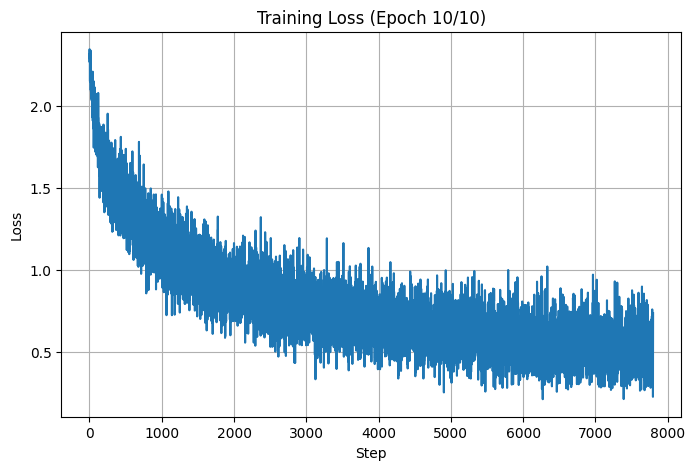

Epoch 10 complete - Loss: 0.5225, Acc: 81.76%


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 28.43it/s]


Test Loss: 0.6250, Test Accuracy: 79.49%


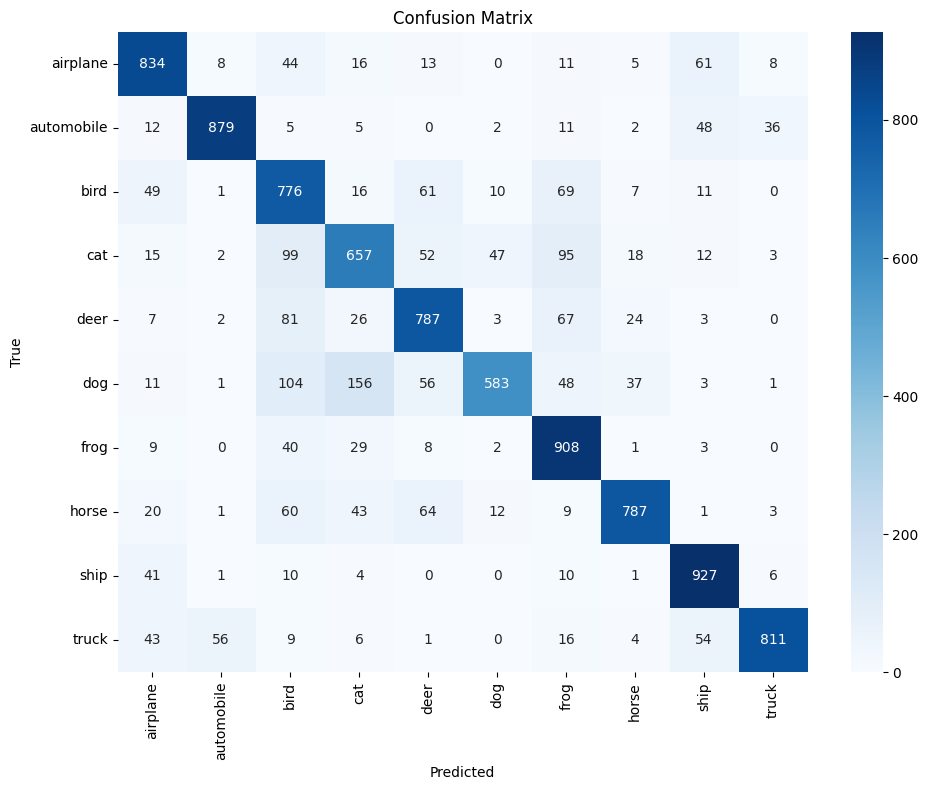

(0.6249574464597519, 79.49)

In [87]:
model_2 = CNN_task2()
model_2 = train(model_2, num_epochs=10)
evaluate(model_2)

# Task 3

I chose to do the rotation prediction augmentation. This allows the model to understand basic aspects of images through learning to predict what amount an image has been rotated.

 <table>
  <tr>
  <td><img src="training_curves/vanilla_train.png" 
  width="400"/><br><center>Vanilla CNN</center></td>
  <td><img src="training_curves/ssl_train.png" 
  width="400"/><br><center>SSL Pretrained CNN</center></td>
  </tr>
</table>

The pretrained CNN was able to get to a loss of ~1.5 in about 500 steps as compared to about 700 steps for the vanilla CNN. The vanilla CNN did eventually catch up and get a better loss, but this is likely because it was trained on the full dataset as compared to just 10% of the dataset. If I was going to try to maximize performance, I would use the pretrained model with the full dataset.

## Define Model

In [88]:
class CNN_task3(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Block 1
        self.conv1a = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.shortcut1 = nn.Conv2d(3, 32, kernel_size=1)
        
        # Block 2
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.shortcut2 = nn.Conv2d(32, 64, kernel_size=1)
        
        # Block 3
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.shortcut3 = nn.Conv2d(64, 128, kernel_size=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

    def forward(self, x):
        identity = self.shortcut1(x)
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(x + identity)
        x = self.pool(x)
        
        identity = self.shortcut2(x)
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(x + identity)
        x = self.pool(x)
        
        identity = self.shortcut3(x)
        x = F.relu(self.conv3a(x))
        x = self.conv3b(x)
        x = F.relu(x + identity)
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Get Data

In [89]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import random

# Base augmentation (without rotation)
ssl_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class RotCIFAR10(Dataset):
    def __init__(self, root='./data'):
        # Use transform=None so we can control rotation order
        self.base = torchvision.datasets.CIFAR10(
            root=root, train=True, download=False, transform=None
        )
        self.transform = ssl_transform
        self.angles = [0, 90, 180, 270]

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, _ = self.base[idx]          # img is PIL Image
        k = random.randint(0, 3)         # rotation class
        angle = self.angles[k]
        img = TF.rotate(img, angle)      # rotate image
        img = self.transform(img)        # then augment + normalize
        rot_label = k                    # 0,1,2,3
        return img, rot_label
    
    
rot_trainset = RotCIFAR10(root='./data')
rot_trainloader = DataLoader(rot_trainset, batch_size=64, shuffle=True)


## Pretrain

In [90]:

def train_rotation(model, rot_trainloader, num_epochs=10, lr=1e-3):
    """Train a model on CIFAR-10 with rotation prediction (4-way)."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Training on: {device}")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    step_losses = []
    fig, ax = plt.subplots(figsize=(8, 5))
    
    step = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, rot_labels in rot_trainloader:
            images = images.to(device)
            rot_labels = rot_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, rot_labels)
            
            loss.backward()
            optimizer.step()
            
            step_losses.append(loss.item())
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += rot_labels.size(0)
            correct += predicted.eq(rot_labels).sum().item()
            step += 1
            
            if step % 50 == 0:
                clear_output(wait=True)
                ax.clear()
                ax.plot(step_losses)
                ax.set_xlabel('Step')
                ax.set_ylabel('Loss')
                ax.set_title(f'Rotation Training Loss (Epoch {epoch+1}/{num_epochs})')
                ax.grid(True)
                display(fig)
        
        print(f"Epoch {epoch+1} complete - "
              f"Loss: {running_loss/len(rot_trainloader):.4f}, "
              f"Rot Acc: {100.*correct/total:.2f}%")
    
    plt.close(fig)
    return model

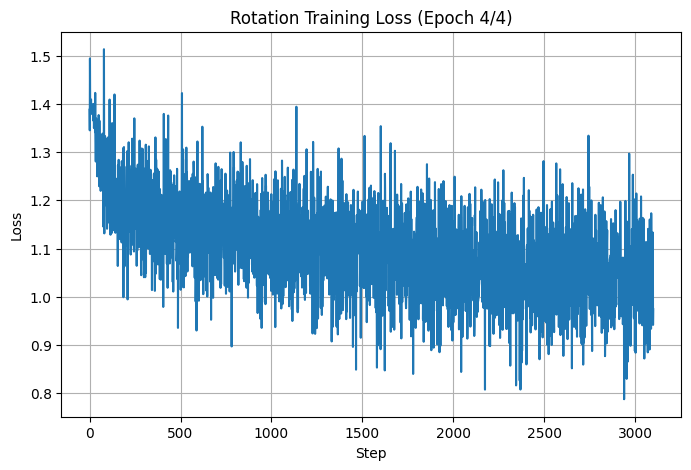

Epoch 4 complete - Loss: 1.0455, Rot Acc: 49.28%


In [79]:
rot_model = CNN_task3(num_classes=4)
rot_model = train_rotation(rot_model, rot_trainloader, num_epochs=4)

## Finetune

In [92]:
from torch.utils.data import Subset
import numpy as np

def get_subset_uniform(dataset, fraction=0.1):
    """Get fraction of data, uniformly sampled across classes."""
    targets = np.array(dataset.targets)
    indices = []
    for class_idx in range(10):
        class_indices = np.where(targets == class_idx)[0]
        n_samples = int(len(class_indices) * fraction)
        selected = np.random.choice(class_indices, n_samples, replace=False)
        indices.extend(selected)
    np.random.shuffle(indices)
    return Subset(dataset, indices)

# Create 10% labeled subset (500 per class = 5000 total)
train_subset = get_subset_uniform(trainset, fraction=0.1)
finetune_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

print(f"Fine-tuning on {len(train_subset)} samples (10% of training data)")

Fine-tuning on 5000 samples (10% of training data)


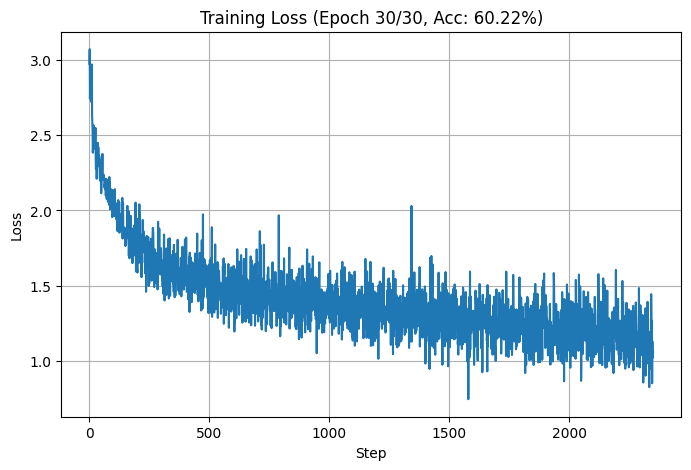

Epoch 30 complete - Loss: 1.1517, Acc: 59.14%


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 27.44it/s]


Test Loss: 1.2478, Test Accuracy: 55.04%


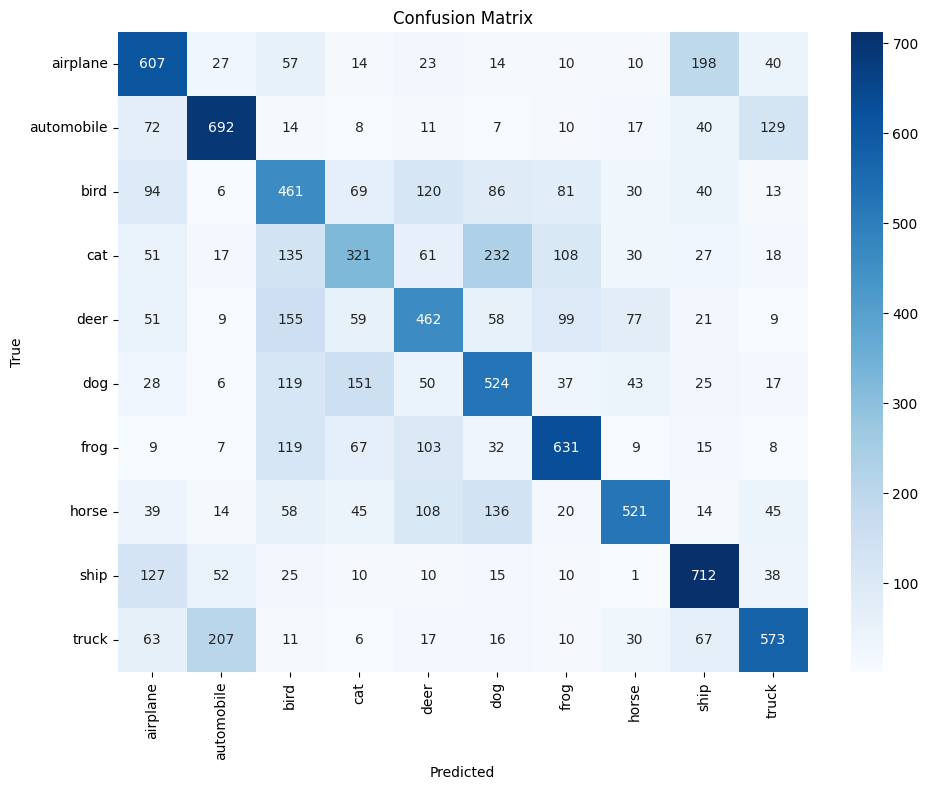

(1.247820379627738, 55.04)

In [94]:
rot_model.fc2 = nn.Linear(256, 10)
rot_model = train(rot_model, num_epochs=30, lr=1e-4, dataloader=finetune_loader)

# Evaluate on full test set
evaluate(rot_model)